In [1]:
import pandas as pd
import numpy as np
from scipy import stats as ss
import pingouin as pg
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import random

Условие задачи:

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [2]:
#подгружаю файлы 
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
active_studs = pd.read_csv('Проект_2_active_studs.csv', sep=';')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
#добавляю флаг активности пользователя is_active (1 - был активным в период эксперимента)
active_studs = active_studs.rename(columns = {'student_id':'id'})
active_studs['is_active'] = 1

In [4]:
active_studs.head()

,id,is_active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [5]:
#объединяю две таблицы в df внешним джоином, чтобы не потерять пользователей из обеих таблиц
#is_active = 0 - пользователи, которые учавствовали в эксперименте, но не были активными 
#пользователи, которые были активные, но не попали в эксперимент имееют группу 0
df = active_studs.merge(groups, how = 'outer', on = 'id')
df['is_active'] = df.is_active.fillna(0)
df['grp'] = df.grp.fillna('0')

In [6]:
df.groupby(['grp', 'is_active'], as_index = False) \
    .agg({'id':'nunique'}) \
    .rename(columns = {'id':'users_cnt'})

,grp,is_active,users_cnt
0,0,1.0,13
1,A,0.0,13136
2,A,1.0,1535
3,B,0.0,53020
4,B,1.0,6793


In [7]:
#переименовываю столбец и добавляю флаг наличия покупки has_check (1 - пользователь сделал целевое действие, сделал покупку)
checks = checks.rename(columns = {'student_id':'id'})
checks['has_check'] = 1

In [8]:
#кол-во повторных покупок = кол-во всего чеков / кол-во уникальных пользователей
checks.rev.count() / checks.id.nunique()

1.0

Делаем вывод, что каждый пользователь в файле Проект_2_checks.csv сделал по одной покупке

In [9]:
#объединяю таблицу df с чеками, left join - чтобы не потерять пользователей без покупок
#has_check = 0  - пользователи, которые не сделали покупку, у них в поле rev сумма чека будет 0
df_x_checks = df.merge(checks, how = 'left', on = 'id')
df_x_checks['has_check'] = df_x_checks.has_check.fillna(0)
df_x_checks['rev'] = df_x_checks.rev.fillna(0)

In [10]:
df_x_checks.groupby(['grp','is_active',  'has_check'], as_index = False) \
    .agg({'rev':'sum', 'id':'nunique'}) \
    .rename(columns = {'rev':'total_sum', 'id':'users_cnt'})

,grp,is_active,has_check,total_sum,users_cnt
0,0,1.0,0.0,0.0000,12
1,0,1.0,1.0,1900.0000,1
2,A,0.0,0.0,0.0000,13107
3,A,0.0,1.0,19276.0000,29
4,A,1.0,0.0,0.0000,1457
5,A,1.0,1.0,72820.0000,78
6,B,0.0,0.0,0.0000,52900
7,B,0.0,1.0,86256.0001,120
8,B,1.0,0.0,0.0000,6480
9,B,1.0,1.0,393074.0035,313


Группировка по флагу активности is_active и наличию чека у пользователся has_check помогает сделать вывод, что в датасэте есть пользователи, которые не были активными во время проведения эксперимента (в группе А 13136, среди них 29 имеют покупки, в группе В 53020, из них 120 пользователей с покупками). 
В данном случае нас интересуют только активные пользователи в дни проведения эксперимента и их покупки.

Мы исследуем гипотезу H0: между значениями сумм чеков в группах А и В различий нет и они примерно равны.
Альтернативная гипотеза Н1: в группах А и В сумма чеков не равны и имеют стат значимые различия.

Однако заметим, что размерность групп А и В не совпадает и различается более чем в 4 раза (1535 против 6793), что дает повода усомнениться в применимости t-test в данном случае.

In [11]:
#отбираю активных пользователей из групп А и В, это наш основной датафрэм
df_x_checks = df_x_checks.query("is_active == 1 & grp != '0'")

In [12]:
df_x_checks.groupby(['grp','is_active','has_check'], as_index = False) \
    .agg({'rev':'sum', 'id':'nunique'}) \
    .rename(columns = {'rev':'total_sum', 'id':'users_cnt'})

,grp,is_active,has_check,total_sum,users_cnt
0,A,1.0,0.0,0.0000,1457
1,A,1.0,1.0,72820.0000,78
2,B,1.0,0.0,0.0000,6480
3,B,1.0,1.0,393074.0035,313


Из результата запроса выше видим, что у нас много пользователей без покупки из-за чего не ясна картина распределения чеков.  

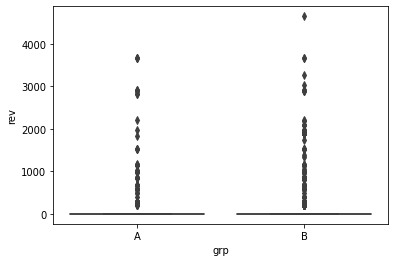

In [13]:
sns.boxplot(x="grp", y="rev", data=df_x_checks)

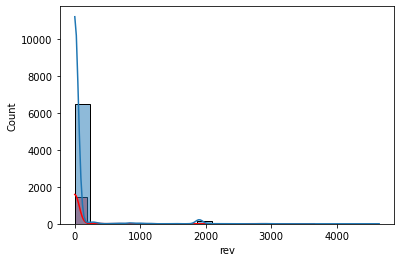

In [14]:
sns.histplot(df_x_checks[df_x_checks.grp == 'A'].rev, bins = 20, kde=True, color = "red")
sns.histplot(df_x_checks[df_x_checks.grp == 'B'].rev, bins = 20, kde=True)

In [15]:
#поэтому оставляю только тех пользователей, которые имеют покупку 
df_x_checks_above0 = df_x_checks[df_x_checks.rev > 0]

In [16]:
df_x_checks_above0

,id,is_active,grp,rev,has_check
62,1184303,1.0,A,1530.0000,1.0
67,3354191,1.0,B,1900.0001,1.0
77,3278734,1.0,B,1900.0000,1.0
99,720651,1.0,A,1980.0000,1.0
193,1232221,1.0,B,1900.0000,1.0
...,...,...,...,...,...
8201,3890326,1.0,B,199.0000,1.0
8204,1390994,1.0,A,398.0000,1.0
8263,1516339,1.0,A,290.0000,1.0
8277,3910596,1.0,B,597.0000,1.0


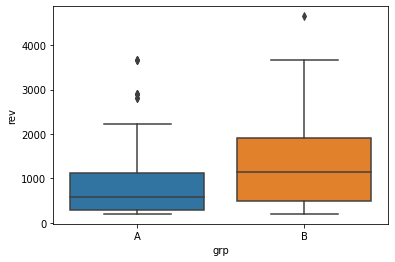

In [17]:
sns.boxplot(x="grp", y="rev", data=df_x_checks_above0)

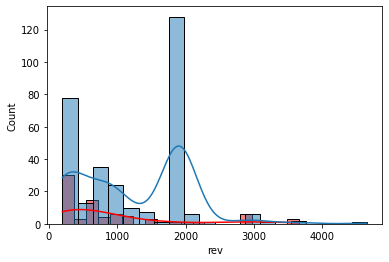

In [18]:
sns.histplot(df_x_checks_above0[df_x_checks_above0.grp == 'A'].rev,bins = 20,  kde=True, color = "red" )
sns.histplot(df_x_checks_above0[df_x_checks_above0.grp == 'B'].rev,bins = 20,  kde=True)

In [19]:
#Тест Шапиро-Уилка и normaltest из библиотеки scipy также показывают, что у нас распределния чеков ненормальные
#мне больше нравится использовать библиотеку pingouin 
pg.normality(data=df_x_checks_above0, dv = "rev", group = 'grp', method = "normaltest")

,W,pval,normal
A,30.37842,2.531687e-07,False
B,7.02227,2.986301e-02,False


In [20]:
#группы А и В имеют одиннаковые дисперсии
pg.homoscedasticity(data=df_x_checks_above0, dv = "rev", group = 'grp')

,W,pval,equal_var
levene,3.055864,0.081235,True


In [21]:
#прологарифмируем значения суммы чеков покупателей и в отдельном датафрэйме сохраняю данные
df_x_checks_above0['rev_log'] = np.log(df_x_checks_above0.rev)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df_x_checks_above0.head()

,id,is_active,grp,rev,has_check,rev_log
62,1184303,1.0,A,1530.0000,1.0,7.333023
67,3354191,1.0,B,1900.0001,1.0,7.549609
77,3278734,1.0,B,1900.0000,1.0,7.549609
99,720651,1.0,A,1980.0000,1.0,7.590852
193,1232221,1.0,B,1900.0000,1.0,7.549609


In [23]:
pg.normality(data=df_x_checks_above0, dv = "rev_log", group = 'grp', method = "normaltest")

,W,pval,normal
A,7.991540,1.839328e-02,False
B,86.649917,1.528304e-19,False


In [24]:
pg.homoscedasticity(data=df_x_checks_above0, dv = "rev_log", group = 'grp')

,W,pval,equal_var
levene,0.107942,0.742677,True


Исходные значения чеков и логарифированые значения в группах А и В имеют ненормальное распределение и размеры выборок сильно различаются, следовательно не выполняются условия для применения t-test. 

Далее пробую применить U-критерий Манна-Уитни для проверки гипотезы H0: распределение значений признака в группе А совпадает с распределением признака в группе В

In [25]:
ss.mannwhitneyu(df_x_checks_above0[df_x_checks_above0.grp == 'A'].rev, df_x_checks_above0[df_x_checks_above0.grp == 'B'].rev)

MannwhitneyuResult(statistic=8990.0, pvalue=0.000273244700505943)

pvalue=0.0002 < 0.05 , следовательно по этому критерию, можем сказать, что распределение в группе А не совпадает с распределением признака в группе В. Но я ничего не могу сказать про средние или сумму чеков. 

Хочу еще рассмотреть такие метрики как средний чек и конверсию в покупку и их изменения в группах.

In [26]:
metrics =  df_x_checks.groupby(['grp'], as_index = False) \
    .agg({'has_check':'mean', 'rev':'mean'}) \
    .rename(columns = {'rev':'mean_check', 'has_check':'CR'})
metrics['CR'] = metrics['CR']*100
metrics

,grp,CR,mean_check
0,A,5.081433,47.439739
1,B,4.607684,57.864567


Видим, что среди всех активных пользователей средний чек в группе В увеличился на 10.425. 
Проверим следующую гипотезу: изменение среднего чека в группах является ли стат значимым.
Буду проверять методом bootstrap с возвращением.

In [27]:
boot_it = 10000
bootstrap_conf_level = 0.95
boot_len = max([len(df_x_checks[df_x_checks.grp == 'A']), len(df_x_checks[df_x_checks.grp == 'B'])])

In [28]:
boot_data = []
for i in tqdm(range(boot_it)): 
    samples_grA = df_x_checks[df_x_checks.grp == 'A'].rev.sample(boot_len, replace = True).values
    samples_grB = df_x_checks[df_x_checks.grp == 'B'].rev.sample(boot_len, replace = True).values
    boot_data.append(np.mean(samples_grB-samples_grA)) 
pd_boot_data = pd.DataFrame(boot_data)

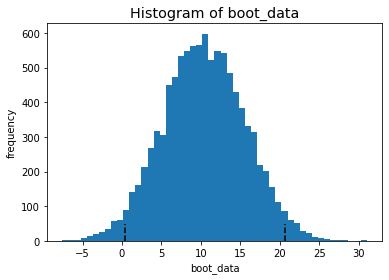

In [29]:
left_quant = (1 - bootstrap_conf_level)/2
right_quant = 1 - (1 - bootstrap_conf_level) / 2
quants = pd_boot_data.quantile([left_quant, right_quant])
        
p_1 = ss.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data) )
p_2 = ss.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
p_value1 = min(p_1, p_2) * 2 
        
    # Визуализация
plt.hist(pd_boot_data[0], bins = 50)
plt.style.use('ggplot')
plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

In [30]:
p_value1

0.04517794303585304

Замечание: 
mean(sample_grB - sample_grA) = mean(sample_grB) - mean(sample_grA); 
mean(sample_grB), mean(sample_grA) - средний чек в бут-выборке соответствующей группы
Следовательно mean(sample_grB - sample_grA) дает разницу между средними чеками бут-выборок.

Применение метода бутстреп к исходной выборке данных групп А и В всех активных пользователей дает следующий результат:
0 не входит в 95% доверительный интервал разницы среднего чека бут-выборок, соответственно мы отклоняем нулевую гипотезу о равенстве выборок и имеем стат значимые различия в группах среди активных пользователей. 

Средний чек в группе A равен 47.439, в группе B 57.864, т.е увеличение среднего чека является стат значимым изменением.

В теории по методу бутстреп говорится, что можно считать разные метрики (среднее, медиана и тд), я решила провести эксперимент и сделать бутстрэп с вычислением конверсии в покупку CR в бут-выборках. Может я делаю исконно неверное применение метода, с чем прошу помощи обьяснить если это так. 

Ранее я считала метрику CR (конверсию в покупку), получается, что у группы A  CR = 5.081, у группы B  CR = 4.607

Выходит, что у тестовой группы B конверсию в покупку упала на 0.474, хочу данную метрику.
Далее проверяю гипотезу: конверсия в группах стат значимо различаются или нет?
В предыдущий раз я считала среднее значение суммы чека в бутвыборке, что является метрикой среднего чека среди активных пользователей.

In [31]:
boot_it = 10000
bootstrap_conf_level = 0.95
boot_len = max([len(df_x_checks[df_x_checks.grp == 'A']), len(df_x_checks[df_x_checks.grp == 'B'])])

In [32]:
boot_data_cr = []
for i in tqdm(range(boot_it)): 
    samples_grA2 = df_x_checks[df_x_checks.grp == 'A'].rev.sample(boot_len, replace = True).reset_index()
    samples_grB2 = df_x_checks[df_x_checks.grp == 'B'].rev.sample(boot_len, replace = True).reset_index()
    CR_grA = samples_grA2[samples_grA2.rev > 0].rev.count() / samples_grA2.rev.count() * 100
    CR_grB = samples_grB2[samples_grB2.rev > 0].rev.count() / samples_grB2.rev.count() * 100
    boot_data_cr.append(CR_grA - CR_grB) 
pd_boot_data_cr = pd.DataFrame(boot_data_cr)

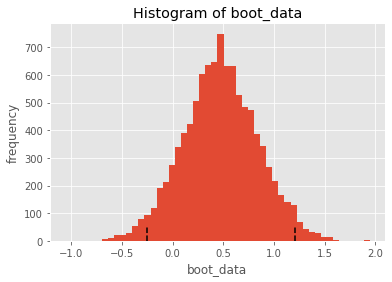

In [33]:
left_quant = (1 - bootstrap_conf_level)/2
right_quant = 1 - (1 - bootstrap_conf_level) / 2
quants = pd_boot_data_cr.quantile([left_quant, right_quant])
        
p_1 = ss.norm.cdf(x = 0, loc = np.mean(boot_data_cr), scale = np.std(boot_data_cr) )
p_2 = ss.norm.cdf(x = 0, loc = -np.mean(boot_data_cr), scale = np.std(boot_data_cr))
p_value1 = min(p_1, p_2) * 2 
        
    # Визуализация
plt.hist(pd_boot_data_cr[0], bins = 50)
plt.style.use('ggplot')
plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Histogram of boot_data")
plt.show()

Обнаружив и исправив свою ошибку в коде, теперь результат эксперимента такой: 0 входит в 95% доверительный интервал разницы конверсий, т.е. можем сделать вывод, что у нас недостаточно оснований отклонить нулевую гипотезу и изменение конверсии не является стат значимым. 

Ранее мы выяснили, что число повторных покупок = 1. Зная величину среднего чека и CR, также можно построить метрики ARPPU и ARPU, где

ARPPU=Число повторных покупок⋅Средний чек => ARPPU = Средний чек

ARPU=Конверсия⋅ARPPU = Конверсия*Средний чек

In [34]:
metrics['ARPU'] = metrics.CR * metrics.mean_check 
metrics

,grp,CR,mean_check,ARPU
0,A,5.081433,47.439739,241.061868
1,B,4.607684,57.864567,266.621661


ИТОГ: новую механику оплаты на всех пользователей можно запускать, если нашей целью является увеличение среднего чека и ARPU, а незначительное уменьшение конверсии НЕ является критичным для бизнеса. 

Дополнительно можно провести какую-нибудь кампанию или акцию, чтобы увеличить кол-во активных пользователей на сайт.

Задача 2.1. Условие:

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [35]:
import pandahouse as ph 

In [36]:
connection = dict(database='default', 
                  host='https://clickhouse.lab.karpov.courses', 
                  user='student', 
                  password='dpo_python_2020')

In [37]:
query = """
select st_id, count(*) as tasks_cnt
from default.peas
where correct = 1
    and toStartOfMonth(timest)  = toDate('2020-03-01', 'YYYY-MM-DD')
group by st_id
having tasks_cnt > 20
"""
df = ph.read_clickhouse(query, connection = connection)
df

,st_id,tasks_cnt


В таблице default.peas нет корректных данных для данного задания, тк максимальное кол-во выполненных заданий в марте месяце не больше 1. Ниже результат моего запроса без условия на 20 задач.

In [38]:
query = """
select st_id, count(*) as tasks_cnt
from default.peas
where correct = 1
    and toStartOfMonth(timest)  = toDate('2020-03-01', 'YYYY-MM-DD')
group by st_id
"""
df = ph.read_clickhouse(query, connection = connection)
df

,st_id,tasks_cnt
0,NVGFYG,1
1,QIP98Q,1
2,KXWNRE,1
3,G8F1CB,1
4,87AU5B,1
5,MECOSF,1
6,1ZXOI6,1


Задача 2.2. Условие:

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [39]:
query = """
with groups as (
  select st_id,     
         test_grp
    from default.studs 
group by st_id, test_grp
)
, activity as (
--считаю активность студентов
  select st_id,  
         subject,
         sum(correct)                   as success_eff, --кол-во решенных задач
         count(1)                       as effort_cnt  --кол-во всего попыток
    from default.peas
group by st_id, subject
)
, checks as (
--считаю кол-во оплат по предметам у каждого студента
  select st_id, 
         subject, 
         money, 
         count(1)                       as purch_cnt
    from default.final_project_check ch 
group by st_id, subject, money
)
, fin_tab as (
  select g.st_id                        as st_id, 
         g.test_grp                     as test_grp, 
         act.subject                    as subject, 
         act.success_eff                as success_eff, 
         act.effort_cnt                 as effort_cnt, 
         case when act.success_eff >1 
         then 1 else 0 end              act_flg, 
         ch.money                       as money, 
         ch.purch_cnt                   as purch_cnt
    from groups g
    left 
    join activity act
      on g.st_id = act.st_id
    left 
    join checks ch
      on g.st_id = ch.st_id
     and act.subject = ch.subject
)
  select test_grp, 
         sum(money*purch_cnt) / count(distinct st_id) AS ARPU, 
         sum(money*purch_cnt) / countIf(distinct st_id, act_flg = 1) AS ARPAU, 
         countIf(distinct st_id, purch_cnt>0) / count(distinct st_id) as CR, 
         countIf(distinct st_id, purch_cnt>0 and act_flg = 1) / countIf(distinct st_id, act_flg = 1) as CR_act, 
         countIf(distinct st_id, purch_cnt>0 and subject = 'Math') / countif(distinct st_id, subject = 'Math') as CR_math
    from fin_tab 
group by test_grp 
"""
df = ph.read_clickhouse(query, connection = connection)
df


,test_grp,ARPU,ARPAU,CR,CR_act,CR_math
0,new,92241.37931,178333.333333,0.965517,0.866667,0.75
1,old,92241.37931,178333.333333,0.965517,0.866667,0.75


В данной задаче аналогичная ситуация с данными в таблице: разница в группах только в двух пользователях ('X272HP', '1EYY37'), которые не сделали покупку и не являются активными (см. данные ниже), поэтому различий в значениях метрик нет.

In [40]:
query = """
with groups as (
  select st_id,     
         test_grp
    from default.studs 
group by st_id, test_grp
)
, activity as (
--считаю активность студентов
  select st_id,  
         subject,
         sum(correct)                   as success_eff, --кол-во решенных задач
         count(1)                       as effort_cnt  --кол-во всего попыток
    from default.peas
group by st_id, subject
)
, checks as (
--считаю кол-во оплат по предметам у каждого студента
  select st_id, 
         subject, 
         money, 
         count(1)                       as purch_cnt
    from default.final_project_check ch 
group by st_id, subject, money
)
, fin_tab as (
  select g.st_id                        as st_id, 
         g.test_grp                     as test_grp, 
         act.subject                    as subject, 
         act.success_eff                as success_eff, 
         act.effort_cnt                 as effort_cnt, 
         case when act.success_eff >1 
         then 1 else 0 end              act_flg, 
         ch.money                       as money, 
         ch.purch_cnt                   as purch_cnt
    from groups g
    left 
    join activity act
      on g.st_id = act.st_id
    left 
    join checks ch
      on g.st_id = ch.st_id
     and act.subject = ch.subject
)
select *
from fin_tab 
where st_id in ('X272HP', '1EYY37')
"""
df = ph.read_clickhouse(query, connection = connection)
df

,st_id,test_grp,subject,success_eff,effort_cnt,act_flg,money,purch_cnt
0,1EYY37,old,Math,0,1,0,0,0
1,X272HP,new,Statistics,0,2,0,0,0
2,X272HP,new,Math,0,1,0,0,0


3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [41]:
def group_add_file(file_path, groups, active_studs, checks):
    groups_add = pd.read_csv(file_path, sep = ',')
    groups = pd.concat([groups, groups_add])  
    df = active_studs.merge(groups, how = 'outer', on = 'id')
    df['is_active'] = df.is_active.fillna(0)
    df['grp'] = df.grp.fillna('0')
    df_x_checks = df.merge(checks, how = 'left', on = 'id')
    df_x_checks['has_check'] = df_x_checks.has_check.fillna(0)
    df_x_checks['rev'] = df_x_checks.rev.fillna(0)
    metrics =  df_x_checks.groupby(['grp'], as_index = False)\
        .agg({'has_check':'mean', 'rev':'mean'}) \
        .rename(columns = {'rev':'mean_check', 'has_check':'CR'})
    metrics['CR'] = metrics['CR']*100
    metrics['ARPU'] = metrics.CR * metrics.mean_check 
    metrics
    return metrics

In [42]:
new_df_metrics = group_add_file('Проект_2_group_add.csv', groups, active_studs, checks)
new_df_metrics['type'] = 'new'
new_df_metrics

,grp,CR,mean_check,ARPU,type
0,A,0.728238,6.268019,4.564609,new
1,B,0.724747,8.036171,5.824187,new


In [43]:
metrics

,grp,CR,mean_check,ARPU
0,A,5.081433,47.439739,241.061868
1,B,4.607684,57.864567,266.621661


In [44]:
def calc_metrics():
    metrics['type'] = 'old'
    metrics_union = pd.concat([metrics, new_df_metrics])
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    sns.pointplot(x="type", y="mean_check", hue = 'grp',  data=metrics_union, capsize=0.8)
    plt.subplot(1, 3, 2)
    sns.pointplot(x="type", y="CR", hue = 'grp',  data=metrics_union, capsize=0.8)
    plt.subplot(1, 3, 3)
    sns.pointplot(x="type", y="ARPU", hue = 'grp',  data=metrics_union, capsize=0.8)

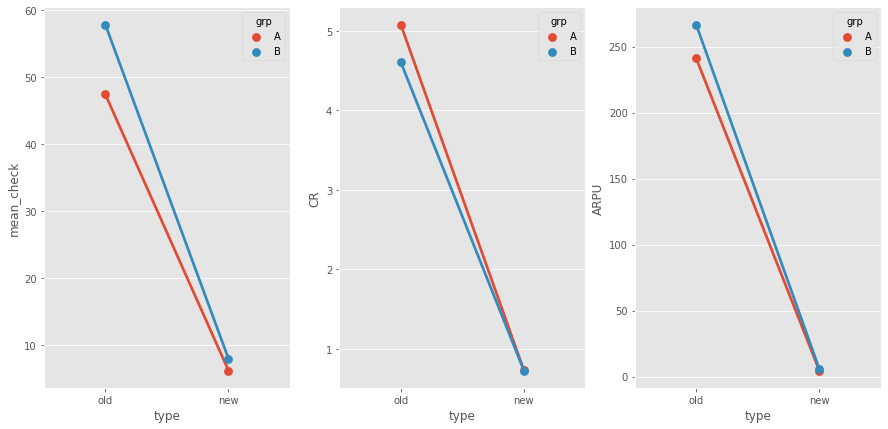

In [45]:
calc_metrics()